# 📈 Stock Price Prediction Dashboard
## Complete Model Training and Analysis Pipeline

This notebook provides end-to-end stock price prediction using machine learning and deep learning models.

## 1. Import Required Libraries

In [2]:
# Install required packages (run this cell first)
%pip install -q yfinance xgboost scikit-learn seaborn matplotlib pandas numpy tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import importlib
import importlib.util
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import yfinance as yf
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras (optional)
tf_spec = importlib.util.find_spec("tensorflow")
if tf_spec is not None:
    tf = importlib.import_module("tensorflow")
    keras_models = importlib.import_module("tensorflow.keras.models")
    keras_layers = importlib.import_module("tensorflow.keras.layers")
    keras_callbacks = importlib.import_module("tensorflow.keras.callbacks")
    Sequential = getattr(keras_models, "Sequential")
    LSTM = getattr(keras_layers, "LSTM")
    Dense = getattr(keras_layers, "Dense")
    Dropout = getattr(keras_layers, "Dropout")
    EarlyStopping = getattr(keras_callbacks, "EarlyStopping")
    TENSORFLOW_AVAILABLE = True
    print("✅ TensorFlow is available - LSTM training enabled")
else:
    tf = None
    Sequential = None
    LSTM = None
    Dense = None
    Dropout = None
    EarlyStopping = None
    TENSORFLOW_AVAILABLE = False
    print("⚠️ TensorFlow not available - LSTM training will be skipped")

print("✅ All libraries imported successfully")

✅ TensorFlow is available - LSTM training enabled
✅ All libraries imported successfully


In [4]:
import importlib
import importlib.util
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import yfinance as yf
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras (optional)
tf_spec = importlib.util.find_spec("tensorflow")
if tf_spec is not None:
    tf = importlib.import_module("tensorflow")
    keras_models = importlib.import_module("tensorflow.keras.models")
    keras_layers = importlib.import_module("tensorflow.keras.layers")
    keras_callbacks = importlib.import_module("tensorflow.keras.callbacks")
    Sequential = getattr(keras_models, "Sequential")
    LSTM = getattr(keras_layers, "LSTM")
    Dense = getattr(keras_layers, "Dense")
    Dropout = getattr(keras_layers, "Dropout")
    EarlyStopping = getattr(keras_callbacks, "EarlyStopping")
    TENSORFLOW_AVAILABLE = True
    print("✅ TensorFlow is available - LSTM training enabled")
else:
    tf = None
    Sequential = None
    LSTM = None
    Dense = None
    Dropout = None
    EarlyStopping = None
    TENSORFLOW_AVAILABLE = False
    print("⚠️ TensorFlow not available - LSTM training will be skipped")

print("✅ All libraries imported successfully")

✅ TensorFlow is available - LSTM training enabled
✅ All libraries imported successfully


## 2. Define Helper Functions

In [5]:
def find_optimal_threshold(y_true, probas, metric_priority="f1"):
    """Determine the decision threshold that maximizes the chosen metric."""
    thresholds = np.linspace(0.1, 0.9, 81)
    best = {
        "threshold": 0.5,
        "f1": 0.0,
        "accuracy": 0.0,
        "precision": 0.0,
        "recall": 0.0,
        "metric": 0.0
    }
    for threshold in thresholds:
        preds = (probas >= threshold).astype(int)
        accuracy = metrics.accuracy_score(y_true, preds)
        f1 = metrics.f1_score(y_true, preds, zero_division=0)
        precision = metrics.precision_score(y_true, preds, zero_division=0)
        recall = metrics.recall_score(y_true, preds, zero_division=0)
        metric_value = f1 if metric_priority == "f1" else accuracy
        if metric_value > best["metric"]:
            best = {
                "threshold": float(threshold),
                "f1": float(f1),
                "accuracy": float(accuracy),
                "precision": float(precision),
                "recall": float(recall),
                "metric": float(metric_value)
            }
    return best


def compute_walk_forward_metrics(model_pipeline, X, y, max_splits=5, min_samples_per_split=120):
    """Run a walk-forward (time-series) evaluation for tabular models."""
    if len(X) < min_samples_per_split * 2:
        return None

    possible_splits = len(X) // min_samples_per_split
    n_splits = min(max_splits, max(2, possible_splits))
    if n_splits < 2:
        return None

    tscv = TimeSeriesSplit(n_splits=n_splits)
    records = []

    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X)):
        if len(train_idx) < min_samples_per_split or len(val_idx) == 0:
            continue

        cloned_model = clone(model_pipeline)
        cloned_model.fit(X.iloc[train_idx], y.iloc[train_idx])
        probas = cloned_model.predict_proba(X.iloc[val_idx])[:, 1]
        preds = (probas >= 0.5).astype(int)

        records.append({
            "fold": fold_idx + 1,
            "train_samples": int(len(train_idx)),
            "valid_samples": int(len(val_idx)),
            "accuracy": float(metrics.accuracy_score(y.iloc[val_idx], preds)),
            "f1": float(metrics.f1_score(y.iloc[val_idx], preds, zero_division=0)),
            "roc_auc": float(metrics.roc_auc_score(y.iloc[val_idx], probas))
        })

    if not records:
        return None

    df_records = pd.DataFrame(records)
    summary = {
        "folds": records,
        "mean_accuracy": float(df_records["accuracy"].mean()),
        "mean_f1": float(df_records["f1"].mean()),
        "mean_roc_auc": float(df_records["roc_auc"].mean()),
        "n_folds": int(len(records))
    }
    return summary


def extract_feature_importance(estimator, feature_names):
    """Return normalized feature importance scores for supported estimators."""
    if estimator is None:
        return None

    model = estimator
    if isinstance(estimator, Pipeline):
        model = estimator.named_steps.get("model", estimator)

    if isinstance(model, VotingClassifier):
        aggregated = {}
        count = 0
        for sub_estimator in model.estimators_:
            if isinstance(sub_estimator, tuple):
                sub_estimator = sub_estimator[1]
            sub_importance = extract_feature_importance(sub_estimator, feature_names)
            if sub_importance:
                count += 1
                for feat, score in sub_importance.items():
                    aggregated[feat] = aggregated.get(feat, 0.0) + float(score)
        if count == 0:
            return None
        for feat in aggregated:
            aggregated[feat] /= count
        return dict(sorted(aggregated.items(), key=lambda x: x[1], reverse=True))

    if isinstance(model, Pipeline):
        model = model.named_steps.get("model", model)

    if hasattr(model, "feature_importances_"):
        importances = np.array(model.feature_importances_, dtype=float)
    elif hasattr(model, "coef_"):
        coef = model.coef_
        if coef.ndim > 1:
            coef = coef[0]
        importances = np.abs(coef.astype(float))
    else:
        return None

    if importances.size != len(feature_names):
        return None

    return dict(sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True))


def calculate_rsi(data, window=14):
    """Calculate RSI (Relative Strength Index)"""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


def create_lstm_sequences(data_array, labels_array, window):
    """Create sequences for LSTM training"""
    X_seq, y_seq = [], []
    for idx in range(window, len(data_array)):
        X_seq.append(data_array[idx - window:idx])
        y_seq.append(labels_array[idx])
    return np.array(X_seq), np.array(y_seq)

print("✅ Helper functions defined")

✅ Helper functions defined


## 3. Configuration Parameters

In [6]:
# Configuration Parameters
symbol = "INFY.NS"  # Stock ticker symbol
start_date = datetime(2015, 1, 1)
end_date = datetime(2025, 11, 15)
validation_split_pct = 20  # Percentage for validation
sequence_length = 60  # LSTM lookback window
lstm_epochs = 80
lstm_batch_size = 32

print(f"📊 Stock Symbol: {symbol}")
print(f"📅 Date Range: {start_date.date()} to {end_date.date()}")
print(f"🔧 Validation Split: {validation_split_pct}%")
print(f"🧠 LSTM Settings: Window={sequence_length}, Epochs={lstm_epochs}, Batch={lstm_batch_size}")

📊 Stock Symbol: INFY.NS
📅 Date Range: 2015-01-01 to 2025-11-15
🔧 Validation Split: 20%
🧠 LSTM Settings: Window=60, Epochs=80, Batch=32


## 4. Download Stock Data

In [7]:
print("📥 Downloading stock data...")
df = yf.download(symbol, start=start_date, end=end_date)

# Handle MultiIndex columns from yfinance
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df.reset_index(inplace=True)

# Check if we have the required columns
required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"❌ Missing required columns: {missing_cols}")

print(f"✅ Data downloaded successfully! Shape: {df.shape}")
print(f"📊 Columns: {list(df.columns)}")
print(f"📅 Trading Days: {df['Date'].nunique()}")
print(f"📍 Missing Values: {df.isnull().sum().sum()}")

# Display first few rows
df.head()

📥 Downloading stock data...


[*********************100%***********************]  1 of 1 completed

✅ Data downloaded successfully! Shape: (2685, 6)
📊 Columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
📅 Trading Days: 2685
📍 Missing Values: 0


Price,Date,Close,High,Low,Open,Volume
0,2015-01-01,367.770752,369.186397,364.511034,366.755569,2002764
1,2015-01-02,374.998077,376.087773,367.323776,367.323776,6778320
2,2015-01-05,371.775635,378.127426,368.348268,374.383410,9937024
3,2015-01-06,364.008118,369.745232,360.264102,368.813883,9667316
4,2015-01-07,365.749756,367.835967,363.225793,366.019838,7249916


## 5. Data Overview & Statistics

In [8]:
# Statistical Summary
print("📈 Statistical Summary:")
df.describe()

📈 Statistical Summary:


Price,Date,Close,High,Low,Open,Volume
count,2685,2685.000000,2685.000000,2685.000000,2685.000000,2.685000e+03
mean,2020-06-10 15:39:37.206703872,940.953719,950.352454,931.597050,941.151073,7.984265e+06
min,2015-01-01 00:00:00,346.069702,351.696263,340.760218,348.684878,0.000000e+00
25%,2017-09-21 00:00:00,446.461395,452.274231,440.461764,444.946315,5.008061e+06
50%,2020-06-18 00:00:00,685.394592,693.591628,680.565754,686.554602,6.641772e+06
75%,2023-02-23 00:00:00,1407.943359,1421.134738,1398.131776,1408.461280,8.901438e+06
max,2025-11-14 00:00:00,1942.221191,1948.777171,1920.756459,1938.093361,1.644050e+08
std,NaN,499.375545,503.656603,494.955926,499.385376,6.516246e+06


## 6. Exploratory Data Analysis

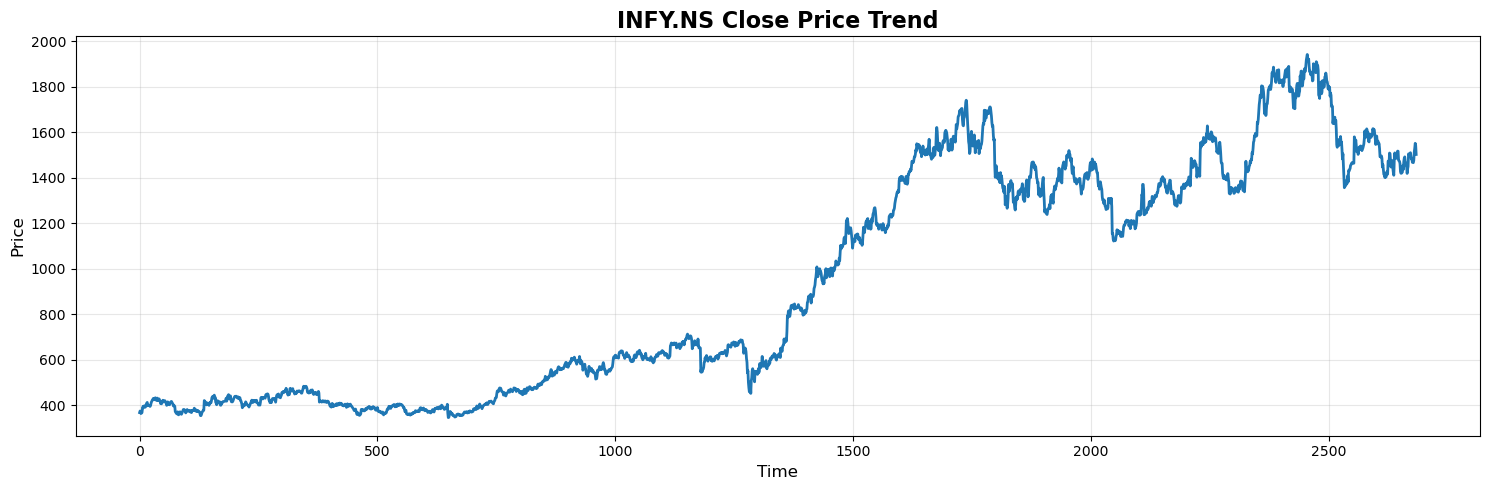

In [9]:
# Close Price Trend
plt.figure(figsize=(15, 5))
plt.plot(df['Close'], linewidth=2, color='#1f77b4')
plt.title(f'{symbol} Close Price Trend', fontsize=16, fontweight='bold')
plt.ylabel('Price', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

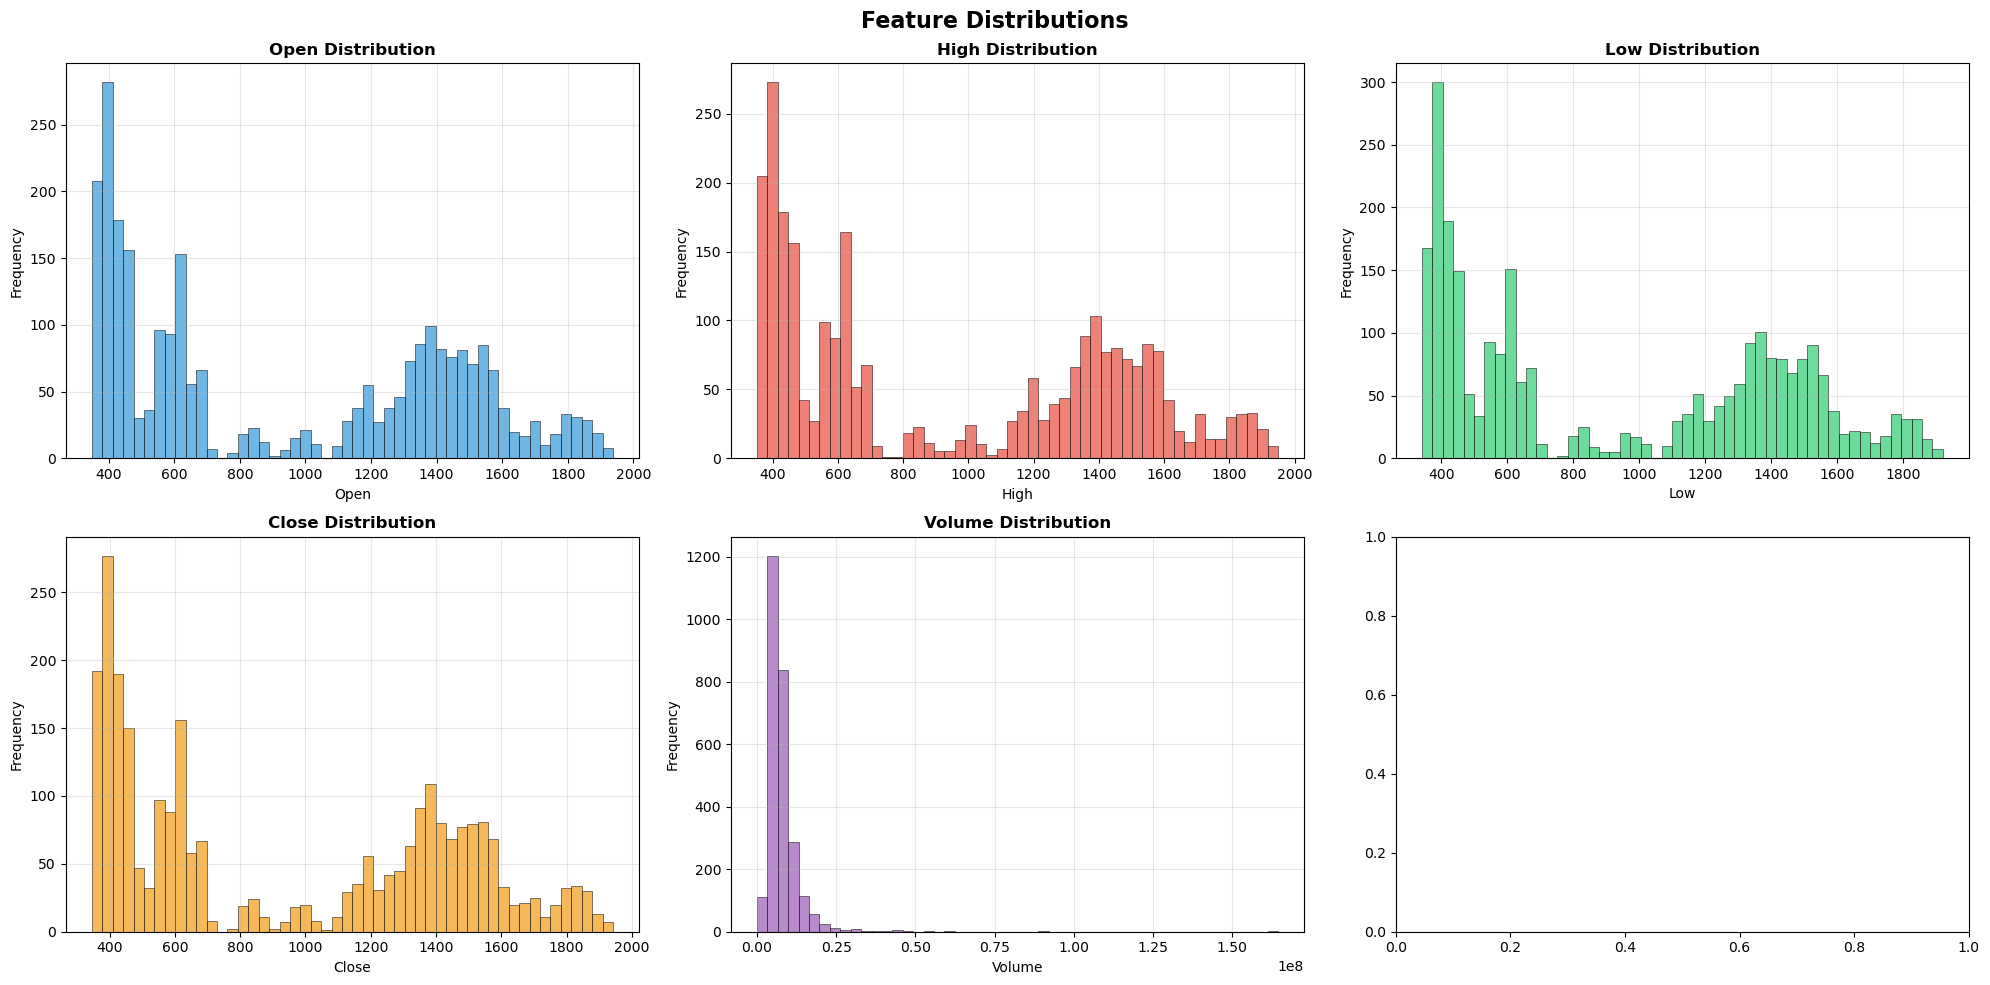

In [10]:
# Distribution Plots
features = ['Open', 'High', 'Low', 'Close', 'Volume']
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Feature Distributions', fontsize=16, fontweight='bold')
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for i, col in enumerate(features):
    if i < 5:
        axes[i // 3, i % 3].hist(
            df[col].dropna(), bins=50, alpha=0.7,
            color=colors[i], edgecolor='black', linewidth=0.5
        )
        axes[i // 3, i % 3].set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
        axes[i // 3, i % 3].set_xlabel(col, fontsize=10)
        axes[i // 3, i % 3].set_ylabel('Frequency', fontsize=10)
        axes[i // 3, i % 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

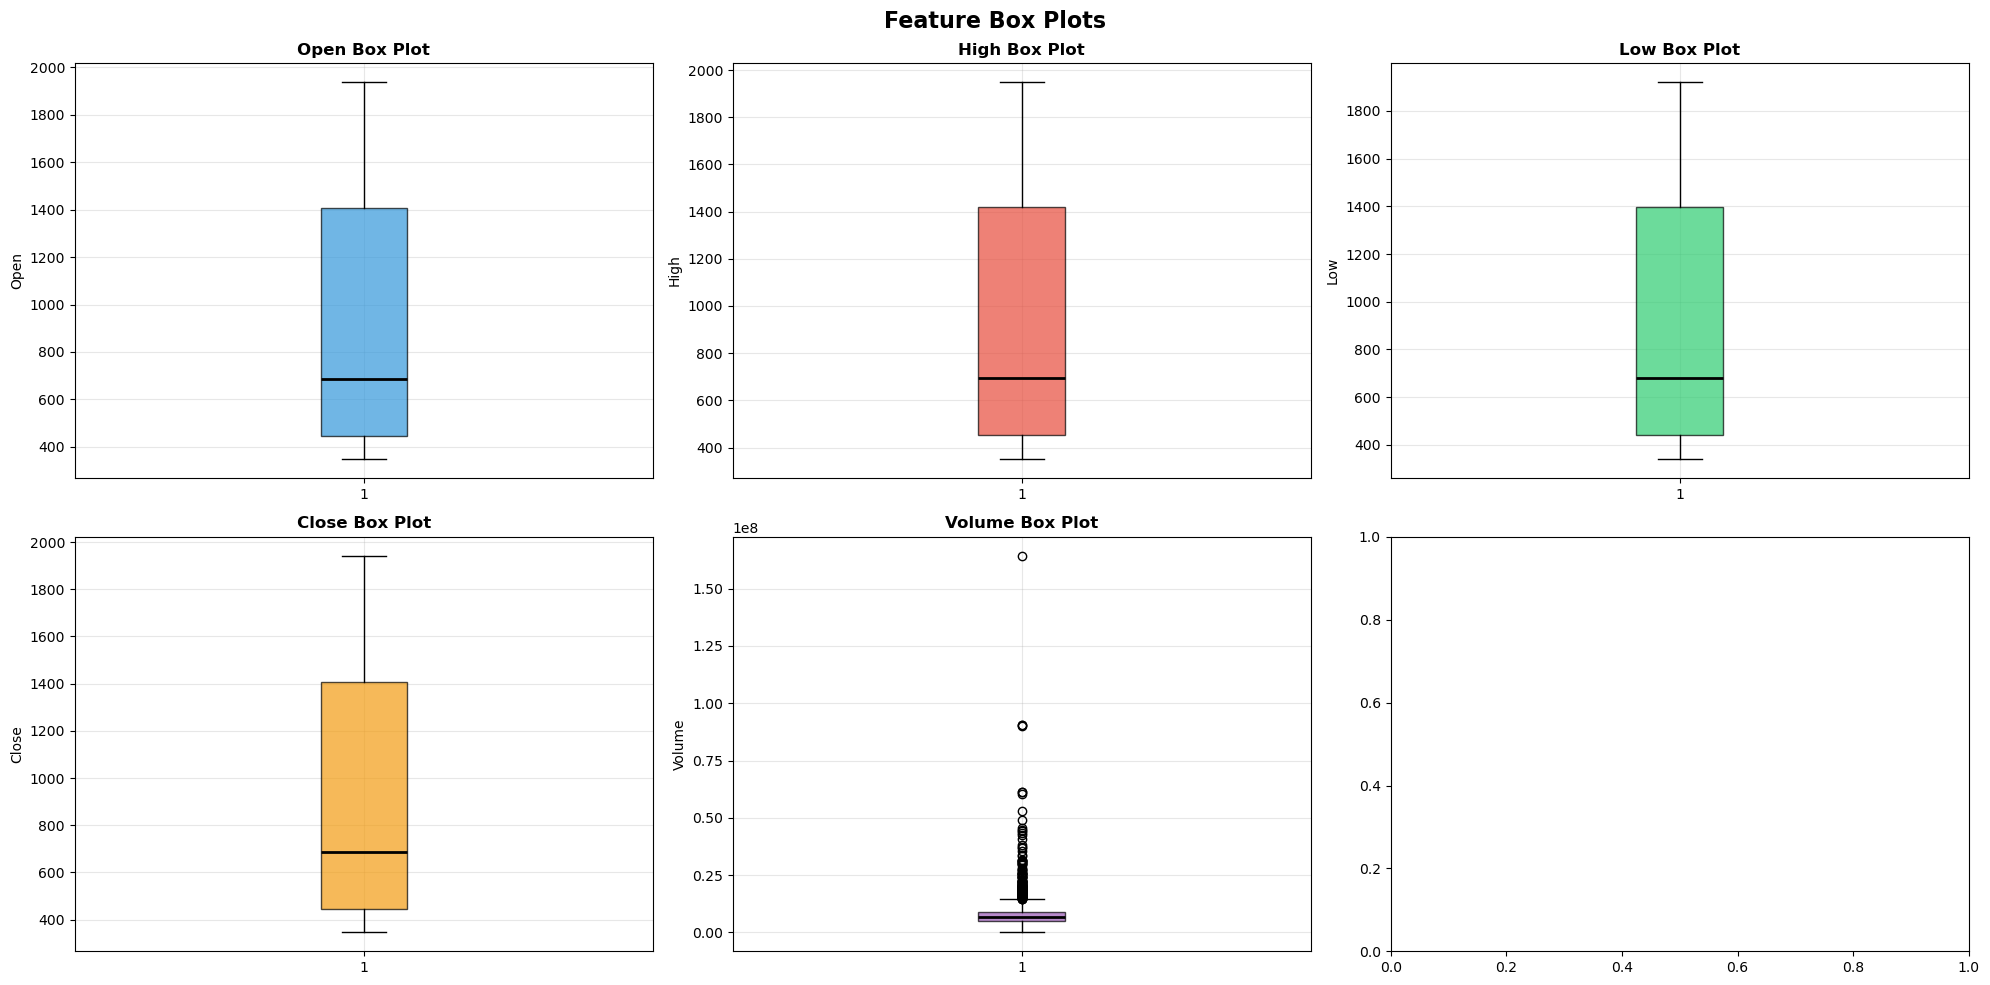

In [11]:
# Box Plots
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Feature Box Plots', fontsize=16, fontweight='bold')

for i, col in enumerate(features):
    if i < 5:
        axes[i // 3, i % 3].boxplot(
            df[col].dropna(), patch_artist=True,
            boxprops=dict(facecolor=colors[i], alpha=0.7),
            medianprops=dict(color='black', linewidth=2)
        )
        axes[i // 3, i % 3].set_title(f'{col} Box Plot', fontsize=12, fontweight='bold')
        axes[i // 3, i % 3].set_ylabel(col, fontsize=10)
        axes[i // 3, i % 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Engineering

In [12]:
df_processed = df.copy()

# Initial cleaning
essential_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
initial_rows = len(df_processed)
df_processed = df_processed.dropna(subset=essential_cols)
after_essential_clean = len(df_processed)

# Returns and momentum (past-only)
df_processed['return_1'] = df_processed['Close'].pct_change()
df_processed['return_5'] = df_processed['Close'].pct_change(5)
df_processed['return_10'] = df_processed['Close'].pct_change(10)
df_processed['momentum_10'] = df_processed['Close'] / df_processed['Close'].shift(10) - 1

# Volatility
df_processed['volatility_10'] = df_processed['return_1'].rolling(window=10).std()

# Moving averages and MACD (past-only)
df_processed['MA_10'] = df_processed['Close'].rolling(window=10).mean()
df_processed['MA_20'] = df_processed['Close'].rolling(window=20).mean()
ema_12 = df_processed['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df_processed['Close'].ewm(span=26, adjust=False).mean()
df_processed['MACD'] = ema_12 - ema_26

# RSI
df_processed['RSI'] = calculate_rsi(df_processed['Close'])

df_processed.replace([np.inf, -np.inf], np.nan, inplace=True)

feature_fill_cols = [
    'return_1', 'return_5', 'return_10',
    'momentum_10', 'volatility_10',
    'MA_10', 'MA_20', 'MACD', 'RSI'
]

# Only forward-fill to avoid using future data, then drop remaining NaNs
df_processed[feature_fill_cols] = df_processed[feature_fill_cols].fillna(method='ffill')
df_processed = df_processed.dropna(subset=feature_fill_cols)

after_feature_clean = len(df_processed)

# Create target variable (next day's price movement)
df_processed['target'] = np.where(df_processed['Close'].shift(-1) > df_processed['Close'], 1, 0)
df_processed = df_processed.iloc[:-1]

print("📊 Data Cleaning Summary:")
print(f"   - Initial data points: {initial_rows}")
print(f"   - After removing rows with missing OHLCV: {after_essential_clean}")
print(f"   - After feature engineering: {after_feature_clean}")
print(f"   - Final dataset: {len(df_processed)} rows")

df = df_processed

if df.empty or len(df) < 30:
    raise ValueError(f"❌ Not enough data after feature engineering. Only {len(df)} rows remain.")

print(f"✅ Feature engineering completed! Final dataset shape: {df.shape}")

📊 Data Cleaning Summary:
   - Initial data points: 2685
   - After removing rows with missing OHLCV: 2685
   - After feature engineering: 2666
   - Final dataset: 2665 rows
✅ Feature engineering completed! Final dataset shape: (2665, 16)


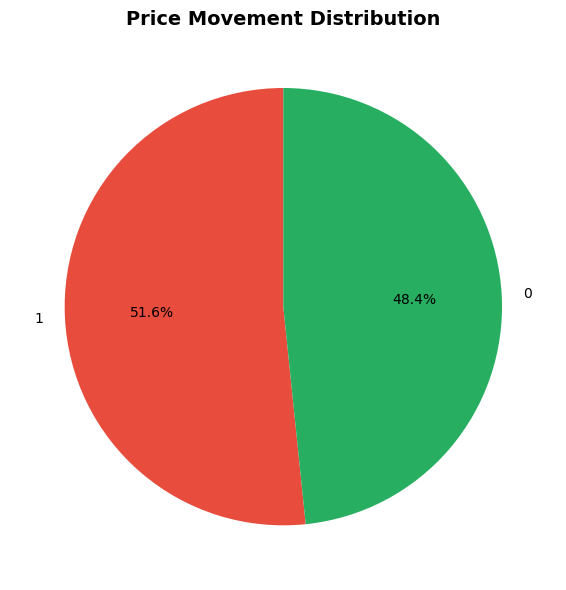

In [13]:
# Target Distribution
plt.figure(figsize=(8, 6))
colors_pie = ['#e74c3c', '#27ae60']
df['target'].value_counts().plot.pie(autopct='%1.1f%%', colors=colors_pie, startangle=90)
plt.title('Price Movement Distribution', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.tight_layout()
plt.show()

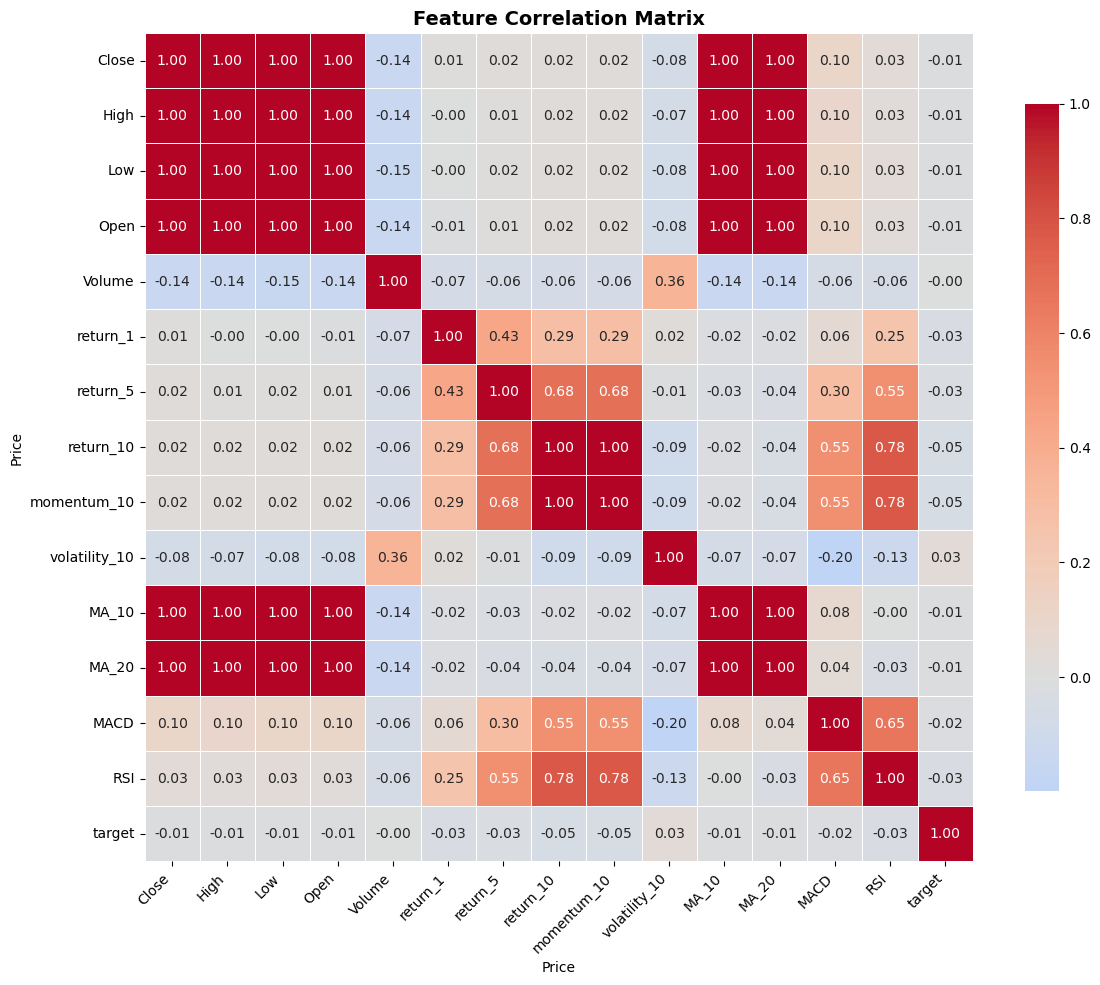

In [14]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
corr_matrix = df.drop('Date', axis=1).corr()
sb.heatmap(
    corr_matrix, annot=True, cmap='coolwarm', center=0,
    cbar_kws={'shrink': 0.8}, square=True, linewidths=0.5, fmt='.2f'
)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 8. Prepare Training and Validation Sets

In [15]:
features_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'return_1', 'return_5', 'return_10',
    'RSI', 'MA_10', 'MA_20', 'MACD',
    'momentum_10', 'volatility_10'
]
features = df[features_cols]
target = df['target']

validation_size = max(int(len(df) * (validation_split_pct / 100)), 1)
train_size = len(df) - validation_size

if train_size <= 0:
    raise ValueError("❌ Validation split too large for the available data.")

X_train = features.iloc[:train_size]
X_valid = features.iloc[train_size:]
Y_train = target.iloc[:train_size]
Y_valid = target.iloc[train_size:]

print(f"📊 Training set shape: {X_train.shape}")
print(f"📊 Validation set shape: {X_valid.shape}")
print(f"✅ Data split completed!")

📊 Training set shape: (2132, 14)
📊 Validation set shape: (533, 14)
✅ Data split completed!


## 9. Train Machine Learning Models

In [16]:
# XGBoost parameters with regularization
xgb_params = {
    "n_estimators": 300,
    "max_depth": 3,
    "learning_rate": 0.05,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "reg_alpha": 1.0,
    "reg_lambda": 2.0,
    "eval_metric": 'logloss',
    "random_state": 2022
}

# Define classical ML models
classical_templates = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000))
    ]),
    "SVM (Poly)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(kernel='poly', probability=True))
    ]),
    "XGBoost": Pipeline([
        ("model", XGBClassifier(**xgb_params))
    ]),
    "Random Forest": Pipeline([
        ("model", RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            min_samples_leaf=5,
            random_state=2022
        ))
    ]),
    "Voting Ensemble": Pipeline([
        ("scaler", StandardScaler()),
        ("model", VotingClassifier(
            estimators=[
                ("lr", LogisticRegression(max_iter=1000)),
                ("xgb", XGBClassifier(**xgb_params)),
                ("rf", RandomForestClassifier(
                    n_estimators=300,
                    max_depth=None,
                    min_samples_leaf=5,
                    random_state=2022
                ))
            ],
            voting='soft'
        ))
    ])
}

lstm_feature_cols = ['Close', 'Volume', 'RSI', 'MA_20', 'volatility_10']

print("✅ Model configurations defined")

✅ Model configurations defined


In [17]:
print("🔄 Training machine learning models...")

trained_models = []
results = []
walk_forward_table = []

# Train classical models
for name, pipeline_template in classical_templates.items():
    print(f"Training {name}...")
    
    pipeline_model = clone(pipeline_template)
    pipeline_model.fit(X_train, Y_train)
    train_probs = pipeline_model.predict_proba(X_train)[:, 1]
    valid_probs = pipeline_model.predict_proba(X_valid)[:, 1]

    train_auc = metrics.roc_auc_score(Y_train, train_probs)
    valid_auc = metrics.roc_auc_score(Y_valid, valid_probs)
    threshold_info = find_optimal_threshold(Y_valid, valid_probs, metric_priority="f1")
    valid_preds_threshold = (valid_probs >= threshold_info["threshold"]).astype(int)
    valid_accuracy = metrics.accuracy_score(Y_valid, valid_preds_threshold)
    valid_f1 = metrics.f1_score(Y_valid, valid_preds_threshold, zero_division=0)

    walk_forward_summary = compute_walk_forward_metrics(pipeline_template, X_train, Y_train)
    if walk_forward_summary:
        walk_forward_table.append({
            "Model": name,
            "WF Folds": walk_forward_summary["n_folds"],
            "WF Mean Accuracy": f"{walk_forward_summary['mean_accuracy']:.4f}",
            "WF Mean F1": f"{walk_forward_summary['mean_f1']:.4f}",
            "WF Mean AUC": f"{walk_forward_summary['mean_roc_auc']:.4f}"
        })

    feature_importances = extract_feature_importance(pipeline_model, features_cols)

    trained_models.append({
        "name": name,
        "type": "classical",
        "model": pipeline_model,
        "eval": {
            "X": X_valid,
            "y": Y_valid
        },
        "latest_features": X_valid.iloc[[-1]] if not X_valid.empty else X_train.iloc[[-1]],
        "threshold": threshold_info,
        "walk_forward": walk_forward_summary,
        "feature_importances": feature_importances,
        "metrics": {
            "Train AUC": train_auc,
            "Valid AUC": valid_auc,
            "Validation Accuracy": valid_accuracy,
            "Validation F1": valid_f1,
            "Validation Precision": threshold_info["precision"],
            "Validation Recall": threshold_info["recall"]
        }
    })

    results.append({
        'Model': name,
        'Train AUC': f"{train_auc:.4f}",
        'Valid AUC': f"{valid_auc:.4f}",
        'Validation Accuracy': f"{valid_accuracy:.4f}",
        'Validation F1': f"{valid_f1:.4f}",
        'Optimal Threshold': f"{threshold_info['threshold']:.2f}"
    })

print("✅ Classical models trained successfully!")

🔄 Training machine learning models...
Training Logistic Regression...
Training SVM (Poly)...
Training SVM (Poly)...
Training XGBoost...
Training XGBoost...
Training Random Forest...
Training Random Forest...
Training Voting Ensemble...
Training Voting Ensemble...
✅ Classical models trained successfully!
✅ Classical models trained successfully!


## 10. Train LSTM Model (Deep Learning)

In [18]:
lstm_ready = TENSORFLOW_AVAILABLE

if lstm_ready:
    if len(X_train) <= sequence_length or len(X_valid) <= sequence_length:
        lstm_ready = False
        print("⚠️ Not enough data for LSTM training")
    else:
        print("🔄 Training LSTM model...")
        
        lstm_scaler = MinMaxScaler()
        train_lstm_features = X_train[lstm_feature_cols]
        valid_lstm_features = X_valid[lstm_feature_cols]

        train_scaled = lstm_scaler.fit_transform(train_lstm_features)
        valid_scaled = lstm_scaler.transform(valid_lstm_features)

        X_train_seq, Y_train_seq = create_lstm_sequences(train_scaled, Y_train.values, sequence_length)
        X_valid_seq, Y_valid_seq = create_lstm_sequences(valid_scaled, Y_valid.values, sequence_length)

        if len(X_train_seq) == 0 or len(X_valid_seq) == 0:
            lstm_ready = False
            print("⚠️ Insufficient sequential data for LSTM")

if lstm_ready:
    lstm_model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(sequence_length, len(lstm_feature_cols))),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    lstm_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    history = lstm_model.fit(
        X_train_seq, Y_train_seq,
        validation_data=(X_valid_seq, Y_valid_seq),
        epochs=lstm_epochs,
        batch_size=lstm_batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    train_probs_lstm = lstm_model.predict(X_train_seq, verbose=0).ravel()
    valid_probs_lstm = lstm_model.predict(X_valid_seq, verbose=0).ravel()
    threshold_info_lstm = find_optimal_threshold(Y_valid_seq, valid_probs_lstm, metric_priority="f1")
    valid_preds_lstm = (valid_probs_lstm >= threshold_info_lstm["threshold"]).astype(int)

    train_auc_lstm = metrics.roc_auc_score(Y_train_seq, train_probs_lstm)
    valid_auc_lstm = metrics.roc_auc_score(Y_valid_seq, valid_probs_lstm)
    valid_accuracy_lstm = metrics.accuracy_score(Y_valid_seq, valid_preds_lstm)
    valid_f1_lstm = metrics.f1_score(Y_valid_seq, valid_preds_lstm, zero_division=0)

    trained_models.append({
        "name": f"LSTM (window={sequence_length})",
        "type": "lstm",
        "model": lstm_model,
        "eval": {
            "X": X_valid_seq,
            "y": Y_valid_seq
        },
        "feature_importances": None,
        "lstm_features": lstm_feature_cols,
        "scaler": lstm_scaler,
        "threshold": threshold_info_lstm,
        "metrics": {
            "Train AUC": train_auc_lstm,
            "Valid AUC": valid_auc_lstm,
            "Validation Accuracy": valid_accuracy_lstm,
            "Validation F1": valid_f1_lstm,
            "Validation Precision": threshold_info_lstm["precision"],
            "Validation Recall": threshold_info_lstm["recall"]
        }
    })

    results.append({
        'Model': f"LSTM (window={sequence_length})",
        'Train AUC': f"{train_auc_lstm:.4f}",
        'Valid AUC': f"{valid_auc_lstm:.4f}",
        'Validation Accuracy': f"{valid_accuracy_lstm:.4f}",
        'Validation F1': f"{valid_f1_lstm:.4f}",
        'Optimal Threshold': f"{threshold_info_lstm['threshold']:.2f}"
    })
    
    print("✅ LSTM model trained successfully!")
elif TENSORFLOW_AVAILABLE:
    print("⚠️ Not enough sequential data to train the LSTM model")
else:
    print("⚠️ TensorFlow not available - LSTM training skipped")

🔄 Training LSTM model...
Epoch 1/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5087 - auc: 0.4844 - loss: 0.6936 - val_accuracy: 0.4926 - val_auc: 0.5151 - val_loss: 0.6956
Epoch 2/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5087 - auc: 0.4844 - loss: 0.6936 - val_accuracy: 0.4926 - val_auc: 0.5151 - val_loss: 0.6956
Epoch 2/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5145 - auc: 0.4810 - loss: 0.6939 - val_accuracy: 0.4926 - val_auc: 0.5209 - val_loss: 0.6966
Epoch 3/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5145 - auc: 0.4810 - loss: 0.6939 - val_accuracy: 0.4926 - val_auc: 0.5209 - val_loss: 0.6966
Epoch 3/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5261 - auc: 0.4979 - loss: 0.6930 - val_accuracy: 0.4905 - val_auc: 0.4997 - val_loss: 0.6935
Epoch 4/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5261 - auc: 0.4979 - loss: 0.6930 - val_accuracy: 0.4905 - val_auc: 0.4997 - val_loss: 0.6935
Epoch 4/80
65/65 ━━━━

## 11. Model Performance Comparison

In [19]:
results_df = pd.DataFrame(results)
print("📊 Model Performance Summary:")
print(results_df)

📊 Model Performance Summary:
                 Model Train AUC Valid AUC Validation Accuracy Validation F1  \
0  Logistic Regression    0.5418    0.5474              0.4841        0.6523   
1           SVM (Poly)    0.4089    0.5437              0.4841        0.6523   
2              XGBoost    0.8620    0.4528              0.4841        0.6523   
3        Random Forest    0.9985    0.4479              0.4841        0.6523   
4      Voting Ensemble    0.9740    0.4479              0.4841        0.6523   
5     LSTM (window=60)    0.5242    0.4899              0.4926        0.6601   

  Optimal Threshold  
0              0.10  
1              0.10  
2              0.10  
3              0.10  
4              0.10  
5              0.10  


In [20]:
# Walk-Forward Validation Summary
if walk_forward_table:
    walk_results_df = pd.DataFrame(walk_forward_table)
    print("\n🔁 Walk-Forward Validation Summary:")
    print(walk_results_df)


🔁 Walk-Forward Validation Summary:
                 Model  WF Folds WF Mean Accuracy WF Mean F1 WF Mean AUC
0  Logistic Regression         5           0.5149     0.5203      0.5265
1           SVM (Poly)         5           0.5166     0.5408      0.5146
2              XGBoost         5           0.4986     0.4259      0.5336
3        Random Forest         5           0.4980     0.3872      0.5300
4      Voting Ensemble         5           0.5155     0.4442      0.5353


In [21]:
# Feature Importance
feature_importance_data = [
    (model['name'], model['feature_importances'])
    for model in trained_models
    if model.get('feature_importances')
]

if feature_importance_data:
    print("\n🏅 Top Feature Importance:")
    for name, importance_dict in feature_importance_data:
        top_items = list(importance_dict.items())[:10]
        print(f"\n{name}:")
        for feat, imp in top_items:
            print(f"  {feat}: {imp:.4f}")


🏅 Top Feature Importance:

Logistic Regression:
  MA_20: 0.6189
  Low: 0.4564
  Open: 0.2578
  MA_10: 0.2064
  High: 0.1472
  return_10: 0.0990
  momentum_10: 0.0990
  volatility_10: 0.0717
  RSI: 0.0413
  Volume: 0.0281

XGBoost:
  High: 0.0795
  MA_20: 0.0760
  volatility_10: 0.0728
  Open: 0.0722
  RSI: 0.0719
  momentum_10: 0.0715
  return_10: 0.0714
  MACD: 0.0714
  return_5: 0.0713
  return_1: 0.0704

Random Forest:
  Volume: 0.0863
  return_1: 0.0829
  volatility_10: 0.0817
  return_5: 0.0807
  RSI: 0.0777
  MACD: 0.0748
  momentum_10: 0.0706
  return_10: 0.0689
  MA_10: 0.0651
  MA_20: 0.0646

Voting Ensemble:
  MA_20: 0.2528
  Low: 0.1941
  Open: 0.1307
  MA_10: 0.1106
  High: 0.0952
  return_10: 0.0802
  momentum_10: 0.0799
  volatility_10: 0.0762
  RSI: 0.0635
  Volume: 0.0625


## 12. Confusion Matrices

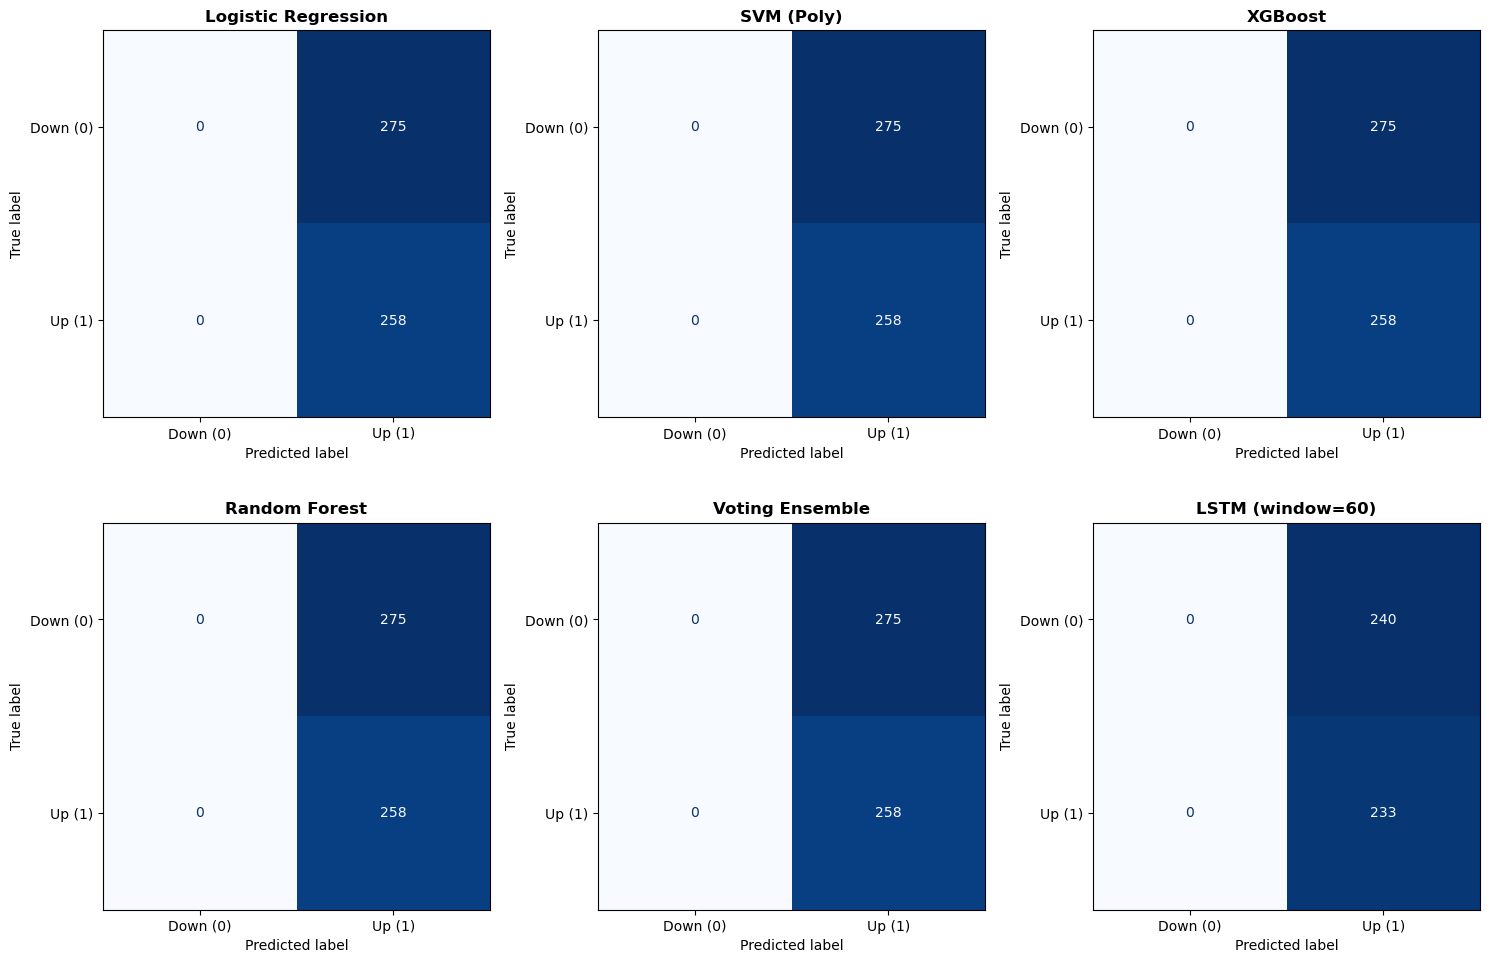

In [22]:
# Generate confusion matrices for all models
num_models = len(trained_models)
cols = 3
rows = (num_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten() if num_models > 1 else [axes]

for idx, model_entry in enumerate(trained_models):
    X_eval = model_entry['eval']['X']
    y_eval = model_entry['eval']['y']
    threshold_value = model_entry.get('threshold', {}).get('threshold', 0.5)
    
    if model_entry['type'] == 'classical':
        probas = model_entry['model'].predict_proba(X_eval)[:, 1]
    else:
        probas = model_entry['model'].predict(X_eval, verbose=0).ravel()
    
    preds = (probas >= threshold_value).astype(int)
    cm = metrics.confusion_matrix(y_eval, preds)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down (0)', 'Up (1)'])
    disp.plot(ax=axes[idx], cmap='Blues', colorbar=False)
    axes[idx].set_title(f'{model_entry["name"]}', fontsize=12, fontweight='bold')

# Hide unused subplots
for idx in range(num_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 13. Next Trading Day Prediction

In [23]:
# Select best model based on Validation F1 score
best_model_entry = max(
    trained_models,
    key=lambda m: m['metrics']['Validation F1']
)

print(f"🏆 Best Model Selected: {best_model_entry['name']}")
print(f"   Validation F1: {best_model_entry['metrics']['Validation F1']:.4f}")

threshold_value = best_model_entry.get('threshold', {}).get('threshold', 0.5)

if best_model_entry['type'] == 'classical':
    latest_features = df[features_cols].iloc[-1:].copy()
    prob_prediction = float(best_model_entry['model'].predict_proba(latest_features)[0][1])
    top_features = best_model_entry.get('feature_importances')
else:
    if len(df) < sequence_length:
        print("⚠️ Not enough recent data points to generate an LSTM prediction.")
    else:
        lstm_features = best_model_entry.get('lstm_features', lstm_feature_cols)
        latest_window = df[lstm_features].iloc[-sequence_length:]
        scaled_window = best_model_entry['scaler'].transform(latest_window)
        lstm_sequence = scaled_window.reshape(
            1, scaled_window.shape[0], scaled_window.shape[1]
        )
        prob_prediction = float(best_model_entry['model'].predict(lstm_sequence, verbose=0).ravel()[0])
        top_features = None

prediction = int(prob_prediction >= threshold_value)
confidence = (prob_prediction if prediction == 1 else 1 - prob_prediction) * 100
confidence = float(confidence)

pred_str = '📈 UP' if prediction == 1 else '📉 DOWN'

print(f"\n🎯 Prediction: {pred_str}")
print(f"🔵 Probability of UP: {prob_prediction * 100:.2f}%")
print(f"💪 Confidence: {confidence:.2f}%")
print(f"🎯 Decision Threshold: {threshold_value:.2f}")
print(f"📊 Expected Direction: Stock price likely to {'MOVE UP' if prediction == 1 else 'MOVE DOWN'}")

if top_features:
    print("\n🔝 Top contributing features:")
    for feature_name, importance_value in list(top_features.items())[:3]:
        print(f"   - {feature_name}: {importance_value:.4f}")
elif best_model_entry['type'] == 'lstm':
    print("\n💡 LSTM contributions are opaque; consider using attention/SHAP for deeper explanations.")

🏆 Best Model Selected: LSTM (window=60)
   Validation F1: 0.6601

🎯 Prediction: 📈 UP
🔵 Probability of UP: 50.14%
💪 Confidence: 50.14%
🎯 Decision Threshold: 0.10
📊 Expected Direction: Stock price likely to MOVE UP

💡 LSTM contributions are opaque; consider using attention/SHAP for deeper explanations.


## 14. Prediction vs Actual Comparison


Model: Logistic Regression
Accuracy: 48.41%
Correct Predictions: 258/533
F1 Score: 0.6523
Threshold: 0.10


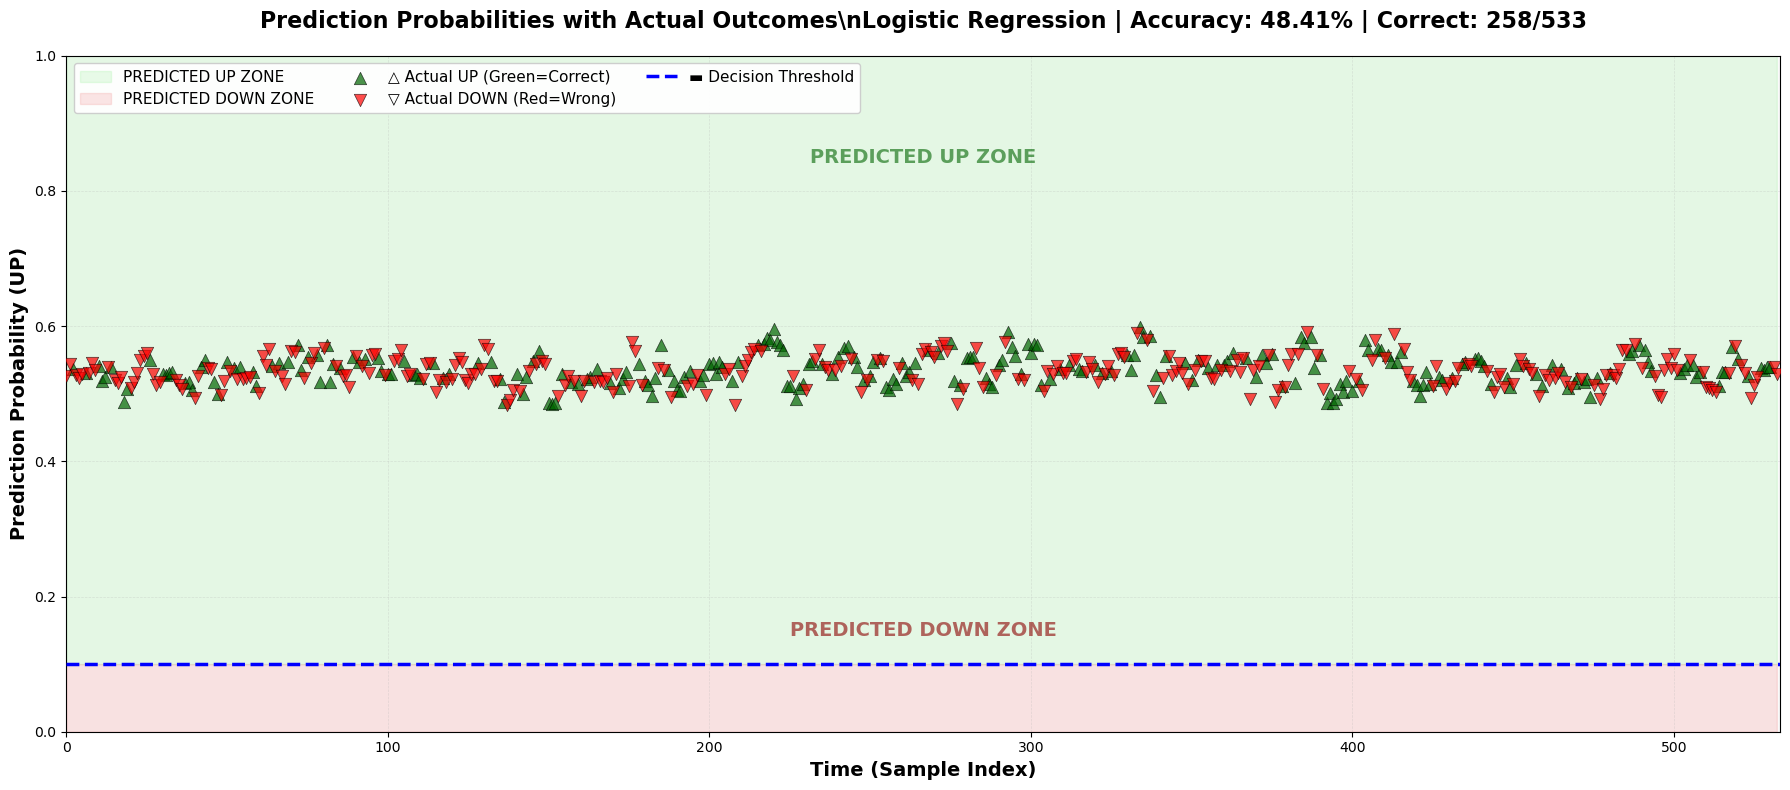

\n📋 Detailed Predictions (Last 20 samples):
      Actual Predicted Probability Match
2664  📉 Down      📈 Up      50.25%     ❌
2665    📈 Up      📈 Up      51.11%     ✅
2666    📈 Up      📈 Up      53.21%     ✅
2667    📈 Up      📈 Up      53.23%     ✅
2668  📉 Down      📈 Up      53.13%     ❌
2669    📈 Up      📈 Up      56.87%     ✅
2670  📉 Down      📈 Up      57.08%     ❌
2671    📈 Up      📈 Up      55.19%     ✅
2672  📉 Down      📈 Up      54.21%     ❌
2673  📉 Down      📈 Up      53.08%     ❌
2674    📈 Up      📈 Up      52.67%     ✅
2675  📉 Down      📈 Up      49.44%     ❌
2676  📉 Down      📈 Up      51.26%     ❌
2677  📉 Down      📈 Up      52.55%     ❌
2678    📈 Up      📈 Up      53.87%     ✅
2679    📈 Up      📈 Up      53.49%     ✅
2680    📈 Up      📈 Up      53.89%     ✅
2681    📈 Up      📈 Up      53.95%     ✅
2682  📉 Down      📈 Up      53.99%     ❌
2683  📉 Down      📈 Up      52.93%     ❌
\n📈 Prediction Statistics:
  By Prediction:
    - Predicted UP: 533 (100.0%)
    - Predicted DO

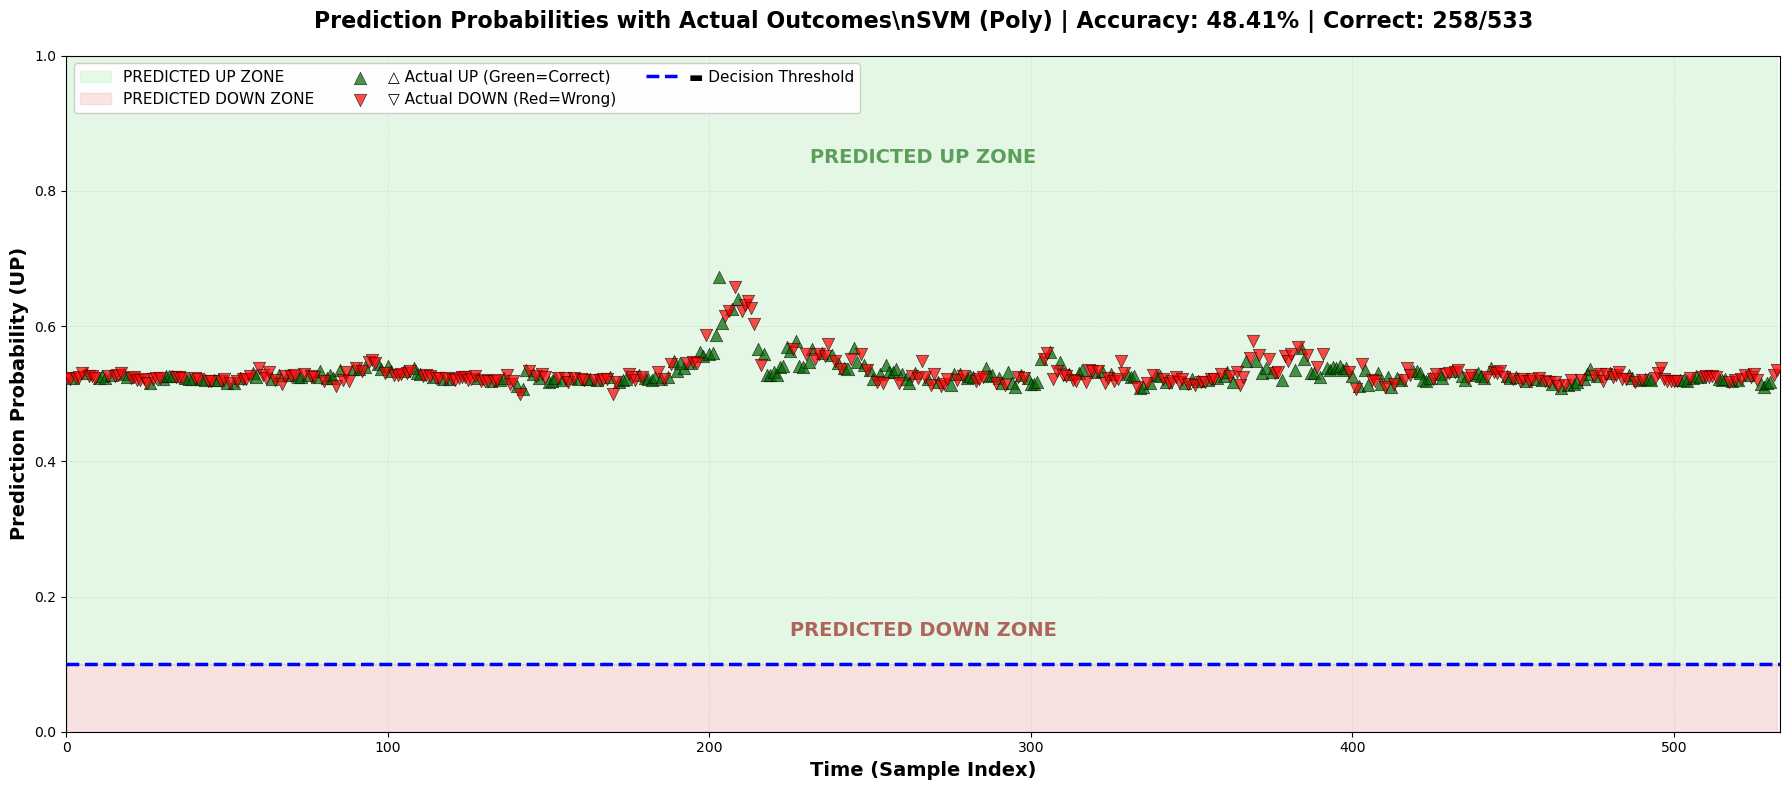

\n📋 Detailed Predictions (Last 20 samples):
      Actual Predicted Probability Match
2664  📉 Down      📈 Up      52.47%     ❌
2665    📈 Up      📈 Up      52.26%     ✅
2666    📈 Up      📈 Up      52.07%     ✅
2667    📈 Up      📈 Up      52.24%     ✅
2668  📉 Down      📈 Up      51.69%     ❌
2669    📈 Up      📈 Up      51.85%     ✅
2670  📉 Down      📈 Up      52.04%     ❌
2671    📈 Up      📈 Up      52.06%     ✅
2672  📉 Down      📈 Up      52.13%     ❌
2673  📉 Down      📈 Up      52.77%     ❌
2674    📈 Up      📈 Up      52.72%     ✅
2675  📉 Down      📈 Up      52.50%     ❌
2676  📉 Down      📈 Up      52.88%     ❌
2677  📉 Down      📈 Up      52.11%     ❌
2678    📈 Up      📈 Up      51.43%     ✅
2679    📈 Up      📈 Up      51.01%     ✅
2680    📈 Up      📈 Up      51.54%     ✅
2681    📈 Up      📈 Up      51.78%     ✅
2682  📉 Down      📈 Up      52.70%     ❌
2683  📉 Down      📈 Up      53.56%     ❌
\n📈 Prediction Statistics:
  By Prediction:
    - Predicted UP: 533 (100.0%)
    - Predicted DO

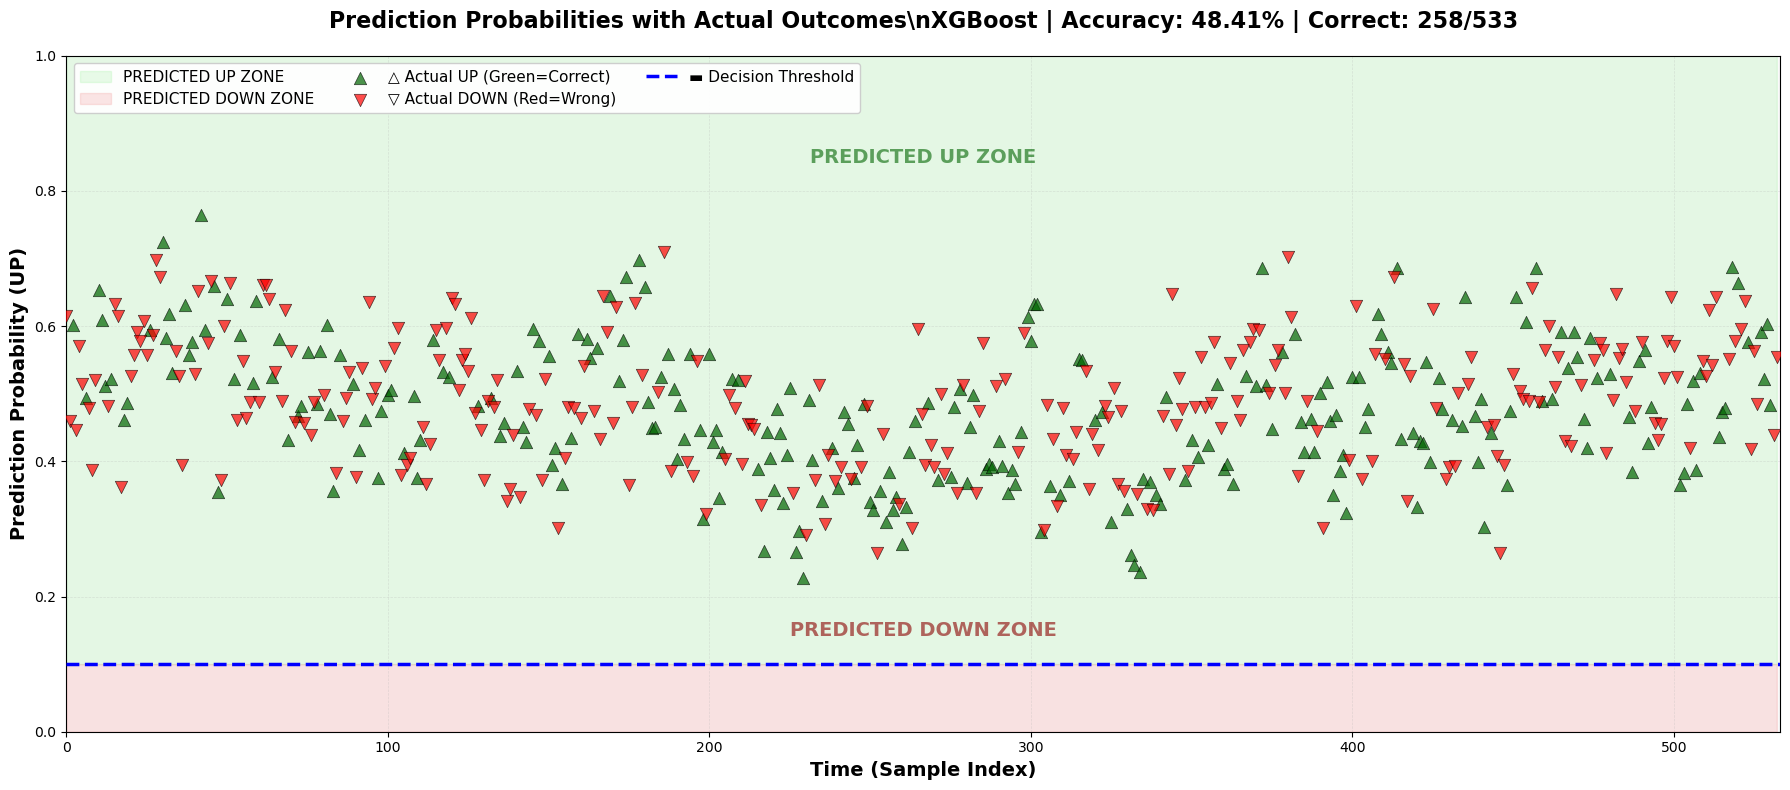

\n📋 Detailed Predictions (Last 20 samples):
      Actual Predicted Probability Match
2664  📉 Down      📈 Up      64.28%     ❌
2665    📈 Up      📈 Up      43.59%     ✅
2666    📈 Up      📈 Up      47.31%     ✅
2667    📈 Up      📈 Up      47.87%     ✅
2668  📉 Down      📈 Up      55.14%     ❌
2669    📈 Up      📈 Up      68.68%     ✅
2670  📉 Down      📈 Up      57.79%     ❌
2671    📈 Up      📈 Up      66.40%     ✅
2672  📉 Down      📈 Up      59.62%     ❌
2673  📉 Down      📈 Up      63.72%     ❌
2674    📈 Up      📈 Up      57.62%     ✅
2675  📉 Down      📈 Up      41.83%     ❌
2676  📉 Down      📈 Up      56.28%     ❌
2677  📉 Down      📈 Up      48.51%     ❌
2678    📈 Up      📈 Up      59.13%     ✅
2679    📈 Up      📈 Up      52.15%     ✅
2680    📈 Up      📈 Up      60.25%     ✅
2681    📈 Up      📈 Up      48.28%     ✅
2682  📉 Down      📈 Up      43.90%     ❌
2683  📉 Down      📈 Up      55.42%     ❌
\n📈 Prediction Statistics:
  By Prediction:
    - Predicted UP: 533 (100.0%)
    - Predicted DO

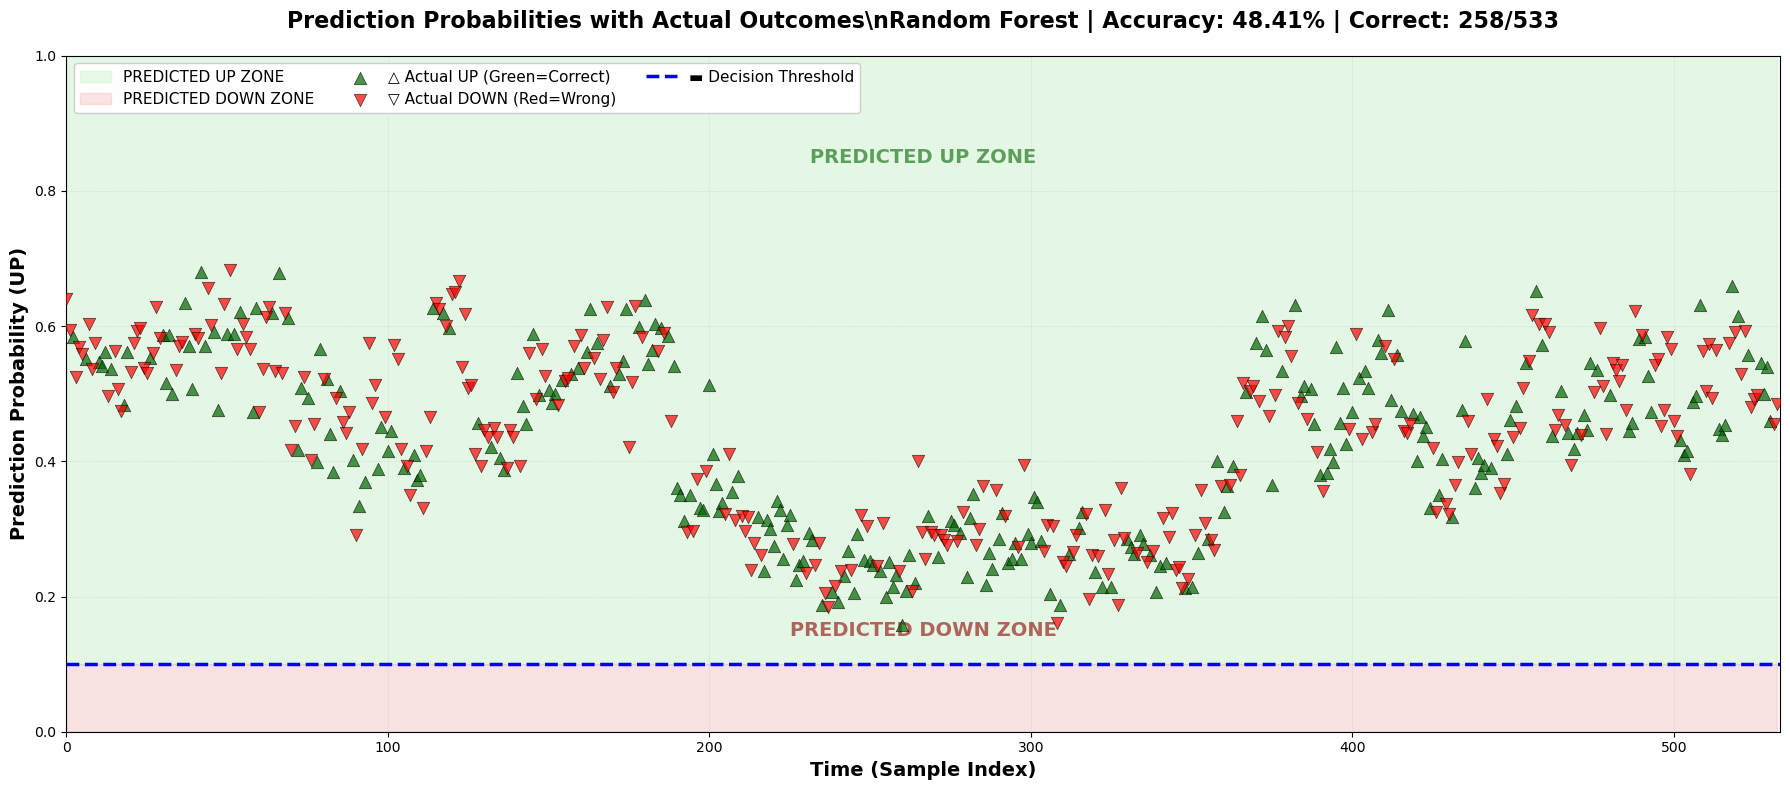

\n📋 Detailed Predictions (Last 20 samples):
      Actual Predicted Probability Match
2664  📉 Down      📈 Up      56.42%     ❌
2665    📈 Up      📈 Up      44.81%     ✅
2666    📈 Up      📈 Up      43.87%     ✅
2667    📈 Up      📈 Up      45.44%     ✅
2668  📉 Down      📈 Up      57.52%     ❌
2669    📈 Up      📈 Up      65.90%     ✅
2670  📉 Down      📈 Up      59.12%     ❌
2671    📈 Up      📈 Up      61.53%     ✅
2672  📉 Down      📈 Up      52.86%     ❌
2673  📉 Down      📈 Up      59.22%     ❌
2674    📈 Up      📈 Up      55.67%     ✅
2675  📉 Down      📈 Up      48.01%     ❌
2676  📉 Down      📈 Up      49.24%     ❌
2677  📉 Down      📈 Up      49.77%     ❌
2678    📈 Up      📈 Up      54.50%     ✅
2679    📈 Up      📈 Up      49.92%     ✅
2680    📈 Up      📈 Up      53.97%     ✅
2681    📈 Up      📈 Up      45.96%     ✅
2682  📉 Down      📈 Up      45.53%     ❌
2683  📉 Down      📈 Up      48.46%     ❌
\n📈 Prediction Statistics:
  By Prediction:
    - Predicted UP: 533 (100.0%)
    - Predicted DO

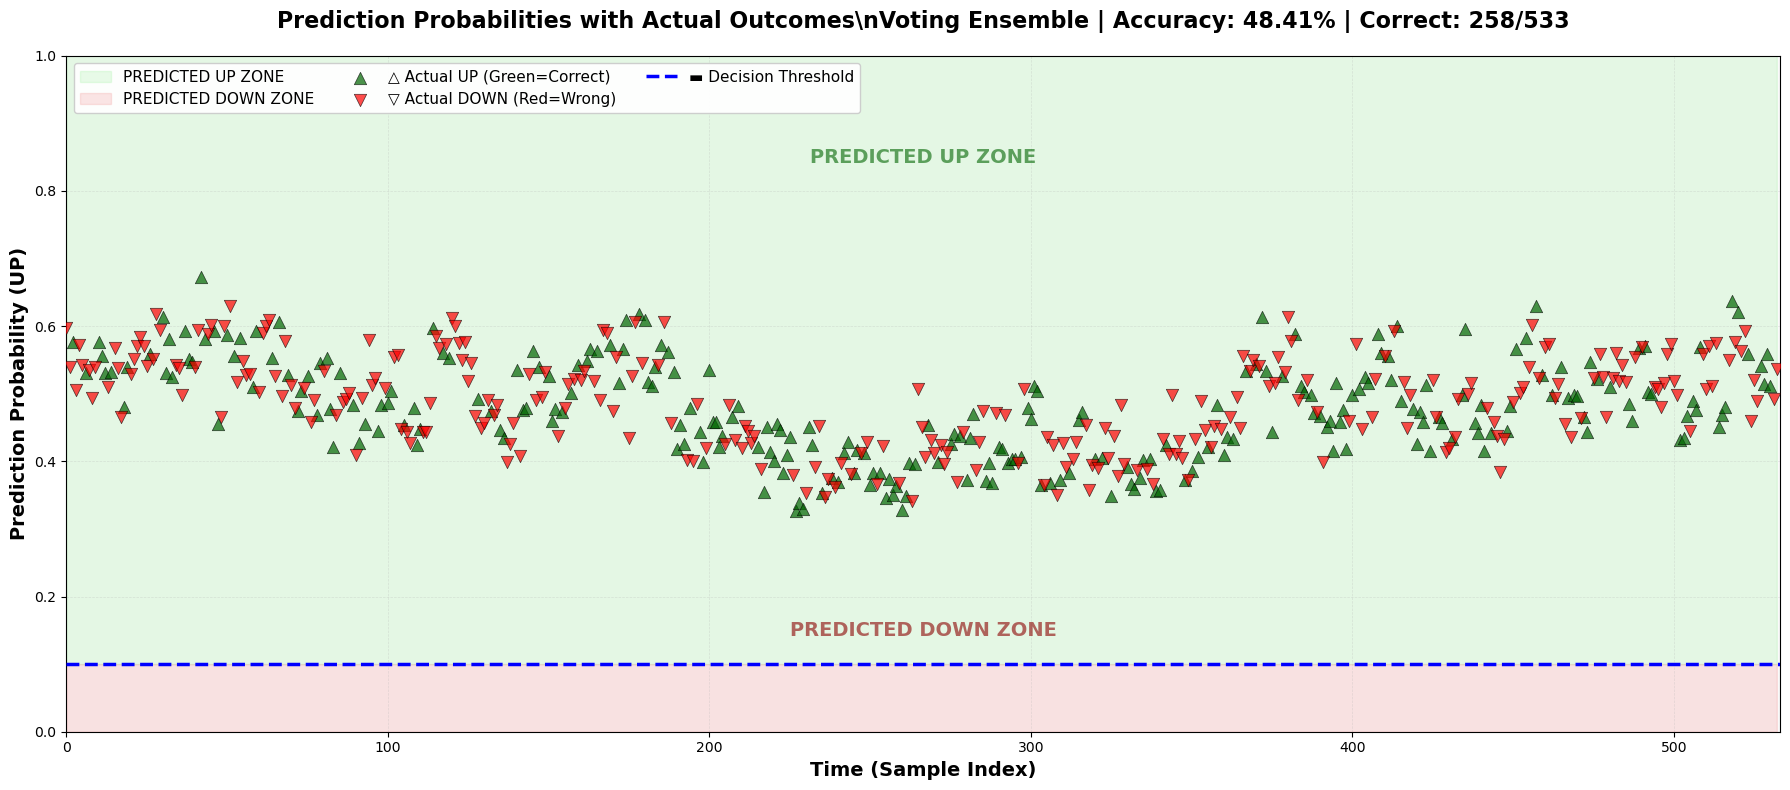

\n📋 Detailed Predictions (Last 20 samples):
      Actual Predicted Probability Match
2664  📉 Down      📈 Up      57.50%     ❌
2665    📈 Up      📈 Up      45.03%     ✅
2666    📈 Up      📈 Up      46.84%     ✅
2667    📈 Up      📈 Up      48.04%     ✅
2668  📉 Down      📈 Up      55.07%     ❌
2669    📈 Up      📈 Up      63.70%     ✅
2670  📉 Down      📈 Up      57.61%     ❌
2671    📈 Up      📈 Up      62.11%     ✅
2672  📉 Down      📈 Up      56.27%     ❌
2673  📉 Down      📈 Up      59.27%     ❌
2674    📈 Up      📈 Up      55.86%     ✅
2675  📉 Down      📈 Up      45.98%     ❌
2676  📉 Down      📈 Up      52.06%     ❌
2677  📉 Down      📈 Up      48.86%     ❌
2678    📈 Up      📈 Up      54.11%     ✅
2679    📈 Up      📈 Up      51.49%     ✅
2680    📈 Up      📈 Up      55.85%     ✅
2681    📈 Up      📈 Up      51.12%     ✅
2682  📉 Down      📈 Up      49.21%     ❌
2683  📉 Down      📈 Up      53.70%     ❌
\n📈 Prediction Statistics:
  By Prediction:
    - Predicted UP: 533 (100.0%)
    - Predicted DO

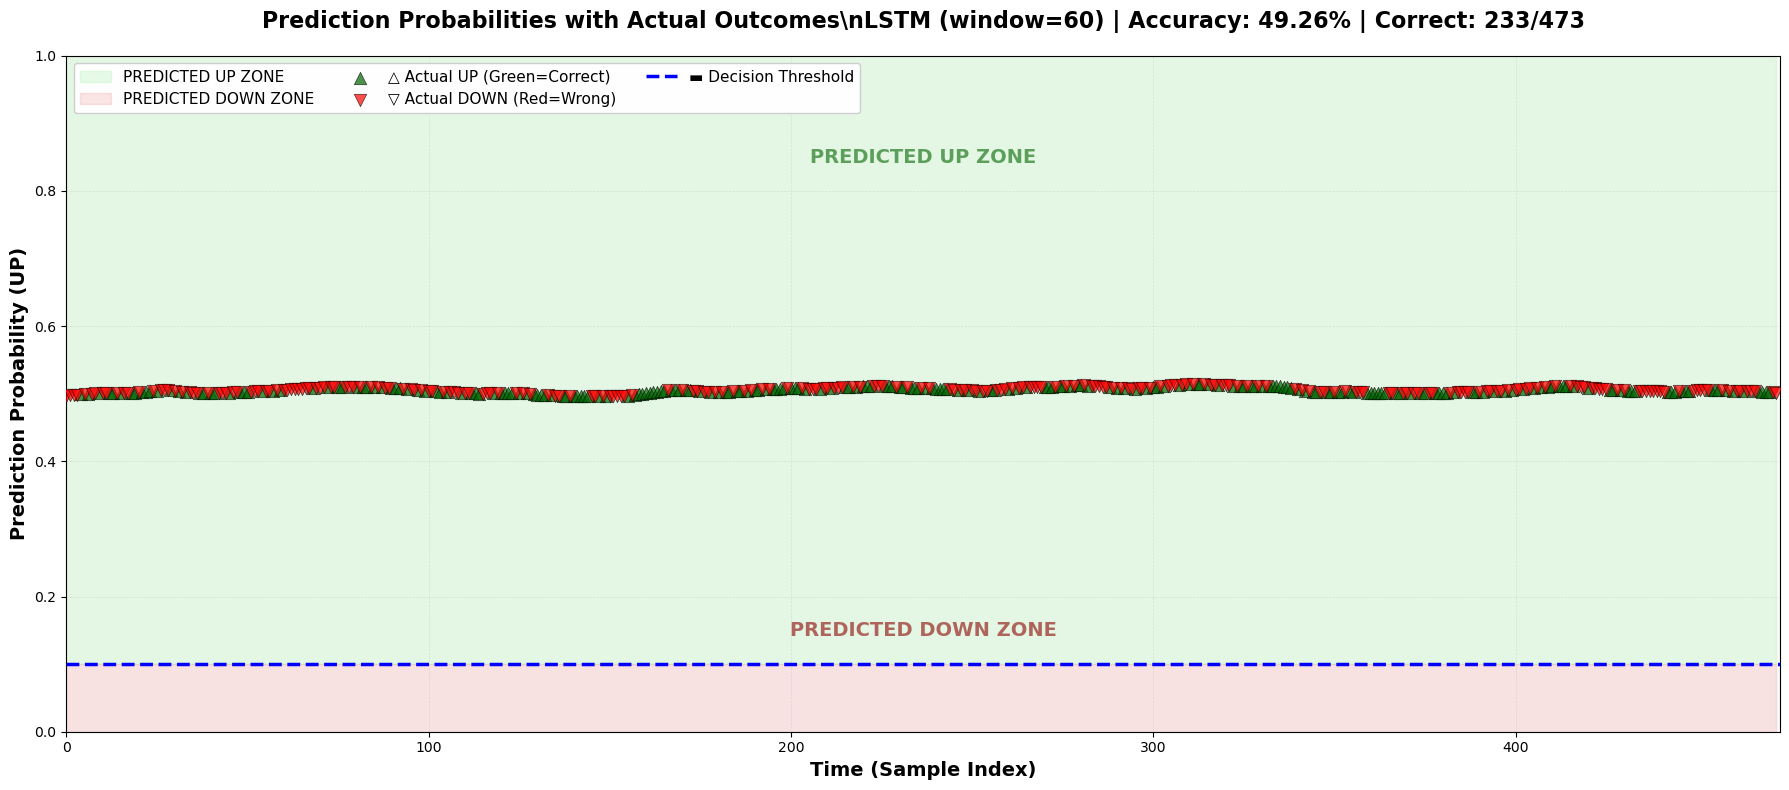

\n📋 Detailed Predictions (Last 20 samples):
     Actual Predicted Probability Match
453  📉 Down      📈 Up      50.53%     ❌
454    📈 Up      📈 Up      50.53%     ✅
455    📈 Up      📈 Up      50.53%     ✅
456    📈 Up      📈 Up      50.52%     ✅
457  📉 Down      📈 Up      50.51%     ❌
458    📈 Up      📈 Up      50.49%     ✅
459  📉 Down      📈 Up      50.47%     ❌
460    📈 Up      📈 Up      50.45%     ✅
461  📉 Down      📈 Up      50.42%     ❌
462  📉 Down      📈 Up      50.40%     ❌
463    📈 Up      📈 Up      50.38%     ✅
464  📉 Down      📈 Up      50.37%     ❌
465  📉 Down      📈 Up      50.36%     ❌
466  📉 Down      📈 Up      50.35%     ❌
467    📈 Up      📈 Up      50.34%     ✅
468    📈 Up      📈 Up      50.31%     ✅
469    📈 Up      📈 Up      50.27%     ✅
470    📈 Up      📈 Up      50.24%     ✅
471  📉 Down      📈 Up      50.20%     ❌
472  📉 Down      📈 Up      50.17%     ❌
\n📈 Prediction Statistics:
  By Prediction:
    - Predicted UP: 473 (100.0%)
    - Predicted DOWN: 0 (0.0%)
  By Act

In [24]:
# Generate Prediction vs Actual plots for all models
for model_entry in trained_models:
    print(f"\n{'='*80}")
    print(f"Model: {model_entry['name']}")
    print(f"{'='*80}")
    
    X_eval = model_entry['eval']['X']
    y_eval = model_entry['eval']['y']
    threshold_value = model_entry.get('threshold', {}).get('threshold', 0.5)
    
    # Get predictions
    if model_entry['type'] == 'classical':
        probas = model_entry['model'].predict_proba(X_eval)[:, 1]
    else:
        probas = model_entry['model'].predict(X_eval, verbose=0).ravel()
    
    preds = (probas >= threshold_value).astype(int)
    
    # Calculate metrics
    accuracy = metrics.accuracy_score(y_eval, preds)
    correct_predictions = (y_eval == preds).sum()
    total_predictions = len(y_eval)
    
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Correct Predictions: {correct_predictions}/{total_predictions}")
    print(f"F1 Score: {model_entry['metrics']['Validation F1']:.4f}")
    print(f"Threshold: {threshold_value:.2f}")
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(18, 8))
    
    # Shade UP and DOWN zones
    ax.fill_between(range(len(probas)), threshold_value, 1.0, alpha=0.2, color='lightgreen', 
                   label='PREDICTED UP ZONE')
    ax.fill_between(range(len(probas)), 0.0, threshold_value, alpha=0.2, color='lightcoral', 
                   label='PREDICTED DOWN ZONE')
    
    # Add zone labels
    ax.text(len(probas) / 2, 0.85, 'PREDICTED UP ZONE', 
           fontsize=14, ha='center', va='center', alpha=0.6, color='darkgreen', fontweight='bold')
    ax.text(len(probas) / 2, 0.15, 'PREDICTED DOWN ZONE', 
           fontsize=14, ha='center', va='center', alpha=0.6, color='darkred', fontweight='bold')
    
    # Get indices for actual outcomes
    up_indices = np.where(y_eval == 1)[0]
    down_indices = np.where(y_eval == 0)[0]
    
    # Determine correct predictions
    correct_up = up_indices[preds[up_indices] == 1]
    wrong_up = up_indices[preds[up_indices] == 0]
    correct_down = down_indices[preds[down_indices] == 0]
    wrong_down = down_indices[preds[down_indices] == 1]
    
    # Plot actual outcomes with triangular markers
    if len(correct_up) > 0:
        ax.scatter(correct_up, probas[correct_up], marker='^', s=80, c='darkgreen', 
                  edgecolors='black', linewidths=0.5, alpha=0.7, zorder=5, 
                  label='△ Actual UP (Green=Correct)')
    
    if len(wrong_up) > 0:
        ax.scatter(wrong_up, probas[wrong_up], marker='^', s=80, c='red', 
                  edgecolors='black', linewidths=0.5, alpha=0.7, zorder=5,
                  label='△ Actual UP (Red=Wrong)')
    
    if len(correct_down) > 0:
        ax.scatter(correct_down, probas[correct_down], marker='v', s=80, c='darkgreen', 
                  edgecolors='black', linewidths=0.5, alpha=0.7, zorder=5, 
                  label='▽ Actual DOWN (Green=Correct)')
    
    if len(wrong_down) > 0:
        ax.scatter(wrong_down, probas[wrong_down], marker='v', s=80, c='red', 
                  edgecolors='black', linewidths=0.5, alpha=0.7, zorder=5,
                  label='▽ Actual DOWN (Red=Wrong)')
    
    # Plot decision threshold
    ax.axhline(y=threshold_value, color='blue', linestyle='--', linewidth=2.5, 
              label=f'▬ Decision Threshold', zorder=4)
    
    # Formatting
    ax.set_xlabel('Time (Sample Index)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Prediction Probability (UP)', fontsize=14, fontweight='bold')
    ax.set_title(f'Prediction Probabilities with Actual Outcomes\\n{model_entry["name"]} | Accuracy: {accuracy:.2%} | Correct: {correct_predictions}/{total_predictions}', 
                fontsize=16, fontweight='bold', pad=20)
    ax.legend(loc='upper left', fontsize=11, framealpha=0.95, ncol=3)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_ylim([0, 1.0])
    ax.set_xlim([0, len(probas)])
    ax.set_facecolor('#fafafa')
    
    plt.tight_layout()
    plt.show()
    
    # Show detailed comparison table (last 20 samples)
    comparison_df = pd.DataFrame({
        'Actual': y_eval,
        'Predicted': preds,
        'Probability': probas,
        'Correct': (y_eval == preds).astype(int)
    })
    
    display_df = comparison_df.tail(20).copy()
    display_df['Actual'] = display_df['Actual'].map({0: '📉 Down', 1: '📈 Up'})
    display_df['Predicted'] = display_df['Predicted'].map({0: '📉 Down', 1: '📈 Up'})
    display_df['Probability'] = display_df['Probability'].apply(lambda x: f"{x:.2%}")
    display_df['Match'] = display_df['Correct'].map({0: '❌', 1: '✅'})
    display_df = display_df[['Actual', 'Predicted', 'Probability', 'Match']]
    
    print("\\n📋 Detailed Predictions (Last 20 samples):")
    print(display_df.to_string())
    
    # Additional statistics
    print("\\n📈 Prediction Statistics:")
    pred_up = (preds == 1).sum()
    pred_down = (preds == 0).sum()
    actual_up = (y_eval == 1).sum()
    actual_down = (y_eval == 0).sum()
    
    print(f"  By Prediction:")
    print(f"    - Predicted UP: {pred_up} ({pred_up/len(preds)*100:.1f}%)")
    print(f"    - Predicted DOWN: {pred_down} ({pred_down/len(preds)*100:.1f}%)")
    print(f"  By Actual:")
    print(f"    - Actual UP: {actual_up} ({actual_up/len(y_eval)*100:.1f}%)")
    print(f"    - Actual DOWN: {actual_down} ({actual_down/len(y_eval)*100:.1f}%)")

## 15. Save Trained Models

In [25]:
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save all trained models
for model_entry in trained_models:
    model_name = model_entry['name'].replace(' ', '_').replace('(', '').replace(')', '').replace('=', '_')
    
    if model_entry['type'] == 'classical':
        # Save classical ML model
        model_path = f'models/{model_name}.pkl'
        joblib.dump(model_entry['model'], model_path)
        print(f"✅ Saved {model_entry['name']} to {model_path}")
    else:
        # Save LSTM model
        model_path = f'models/{model_name}.h5'
        model_entry['model'].save(model_path)
        
        # Also save the scaler
        scaler_path = f'models/{model_name}_scaler.pkl'
        joblib.dump(model_entry['scaler'], scaler_path)
        print(f"✅ Saved {model_entry['name']} to {model_path}")
        print(f"✅ Saved scaler to {scaler_path}")

# Save the best model separately
best_model_name = best_model_entry['name'].replace(' ', '_').replace('(', '').replace(')', '').replace('=', '_')
if best_model_entry['type'] == 'classical':
    joblib.dump(best_model_entry['model'], f'models/best_model_{best_model_name}.pkl')
    print(f"\n🏆 Best model saved as: models/best_model_{best_model_name}.pkl")
else:
    best_model_entry['model'].save(f'models/best_model_{best_model_name}.h5')
    joblib.dump(best_model_entry['scaler'], f'models/best_model_{best_model_name}_scaler.pkl')
    print(f"\n🏆 Best model saved as: models/best_model_{best_model_name}.h5")

print(f"\n✅ All models saved successfully!")

✅ Saved Logistic Regression to models/Logistic_Regression.pkl
✅ Saved SVM (Poly) to models/SVM_Poly.pkl
✅ Saved XGBoost to models/XGBoost.pkl
✅ Saved Random Forest to models/Random_Forest.pkl
✅ Saved Voting Ensemble to models/Voting_Ensemble.pkl


✅ Saved LSTM (window=60) to models/LSTM_window_60.h5
✅ Saved scaler to models/LSTM_window_60_scaler.pkl

🏆 Best model saved as: models/best_model_LSTM_window_60.h5

✅ All models saved successfully!


## 16. Summary

This notebook successfully:
- Downloaded and preprocessed stock data
- Performed feature engineering with technical indicators
- Trained multiple ML models (Logistic Regression, SVM, XGBoost, Random Forest, Voting Ensemble)
- Trained LSTM deep learning model (if TensorFlow available)
- Evaluated all models with comprehensive metrics
- Generated confusion matrices and prediction visualizations
- Made next-day price movement predictions
- Saved all trained models for future use

All trained models are saved in the `models/` directory and can be loaded for making predictions on new data.